## Домашнее задание №4. Работа с NPV моделью.

*Дата выдачи: 17.04.2024*

*Дедлайн: 08.05.2024 23:59*

### Задание №1. Построить распределение клиентов по кривым.
- Использовать DEF, CLO, DLQ кривые из прошлой домашки
- Интерполировать и экстраполировать кривые для каждого значения PA/PD
- PA – x_score из вашей домашки


### Задание №2. Добавить страховку в NPV модель.
- Страховка стоит 0.5% от лимита
- Подключена у 40% клиентов в статусе CUR и у 60% в статусе DLQ
- Возможно наступление страхового случая с вероятностью 0.1%, при подключенной страховке мы должны возместить всю сумму текущей задолженности


Вам нужно внести изменения в код ниже. Где – подсказывать не будем, это часть задания. Добавьте комментарий с указанием мест, которые были изменены/добавлены.

## Импорты и подгрузка кривых

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set_theme()

In [ ]:
df_def_rate = pd.read_csv("/content/def_rate.csv")
df_clo_rate = pd.read_csv("/content/clo_rate.csv")
df_dlq_ratio = pd.read_csv("/content/dlq_ratio.csv")

## Первое задание

Сперва реализуем функцию для интерполяции заданных кривых, как это было показано на лекции

In [ ]:
def interpolation(data: pd.DataFrame, score: float):
    '''
    Линейная интерполяция поведенческих кривых
    :param score: скор клиента
    :param data: данные
    :return:
    result : np.array(101) : интерполированные значения
    '''
    means = data.loc[0] # Cредние значения скоров в бакетах
    result = np.zeros(101) # Итоговый результат интеполяции

    # Смотрим, к какому интервалу между бакетами ближе
    if score >= means['1']:
        delta = data.loc[1:, "2"] - data.loc[1:, "1"]
        delta_score = means['2'] - means['1']
        # Смотрим, от какого бакета надо отсчитывать при интерполировании
        if score >= means['2']:
            score -= means['2']
            interp = data.loc[1:, "2"] + delta / delta_score * score
        else:
            score -= means['1']
            interp = data.loc[1:, "1"] + delta / delta_score * score
    else:
        delta = data.loc[1:, "1"] - data.loc[1:, "0"]
        delta_score = means['1'] - means['0']
        score -= means['0']
        interp = data.loc[1:, "0"] + delta / delta_score * score

    # Записываем полученную интерполяцию в result и забиваем последним значением до конца
    interp = interp.values
    result[1:data.shape[0]] = interp
    result[data.shape[0]:] = interp[-1]

    # Дополнительном устанавливаем границы сверху и снизу
    return result.clip(0, 1)

Проверим что интерполяция работает нормально

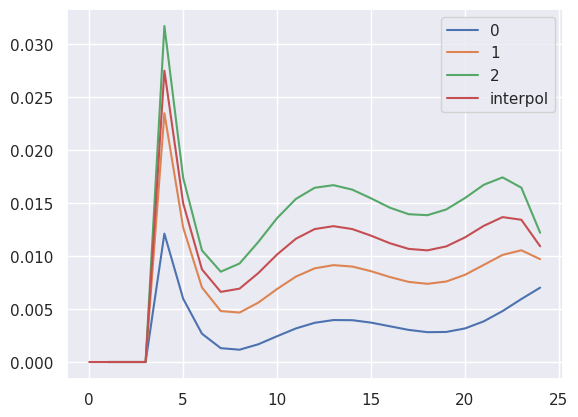

In [ ]:
inter = interpolation(df_def_rate, 0.05)
df_def_rate.iloc[1:][['0', '1', '2']].plot()
sns.lineplot(inter[:25], label='interpol')

plt.show()

Теперь, соответственно, перепишем функцию для расчета распределений клиента по состояниям. Пересчет сделаем по следующему итеративному алгоритму:

0. По переданным pd_score и pa_score происходит интерполирование требуемых кривых dlq_ratio, clo_rate, def_rate
1. В начальный момент времени (t = 0, момент взятия кредита) клиент всегда находится в состоянии CUR;
2. Расчет новых вероятностей происходит итеративно по всем заложенным платежам, новые вероятности основываются на предыдущих вероятностях:
    * Сперва расчитываеся вероятность нахождения в DEF, для чего к вероятности нахождения в DEF на предыдущей выплате прибавляется вероятность выпасть в DEF из состояния CUR на текщуем платеже, которую можно найти через заданный def_rate (по определению, эта добавка и будет вычисляться как def_rate * вероятность ACT на предыдущем платеже);
    * Затем, аналогичным образом находится вероятность нахождения в CLO;
    * Вероятность нахождения в статусе ACT соответственно будет вычисляться путем вычитания найденных выше значений из 1;
    * Наконец, распределение внутри ACT по статусам CUR и DLQ находится с помощью dlq_ratio (для DLQ как act * dlq_ratio, а для CUR - как act - dlq)
3. В последнем платеже у нас может оставаться некоторая вероятность нахождения клинета в статусах CUR и DLQ; поэтому, для адекватной сходимости, будем считать, что если в последний платеж клиент находится в CUR, то это значит, что он не имеет задолженностей, т.е. выплатил весь кредит, и мы можем отправить его в статус CLO; если же клиент находится в статусе DLQ, то у него есть задолженности, а значит кредит он не выплатил полностью, следовательно логично будет отправить его в статус DEF

Ниже этот алгоритм реализован как отдельная функция, в классе же он встроен через такой же метод. Чтобы наглядно отобразить результат работы, дополнительно написана функция для отрисовки распределений по платежам (попытался сделать что-то похожее на аналогичные картинки из презентации); метод отрисовки в класс NPV не включен

In [ ]:
def distribution_calc(pd_score:float, pa_score:float, term: int, def_rate, clo_rate, dlq_ratio):
        '''
        Построение графика распределений клиентов
        :param pd_score: вероятность дефолта к 12-ому месяцу
        :param pa_score: вероятность полного досрочного погашения к 6-ому месяцу
        :param term: срок кредитования
        :param plot: строить график
        :return:
        cur_dist: np.array(101) : распределение статуса cur
        clo_dist: np.array(101) : распределение статуса clo
        dlq_dist: np.array(101) : распределение статуса dlq
        def_dist: np.array(101) : распределение статуса def
        '''
        # Интерполяция по значениям pd_score и pa_score
        def_rate = interpolation(def_rate, pd_score)
        clo_rate = interpolation(clo_rate, pa_score)
        dlq_ratio = interpolation(dlq_ratio, pd_score)

        # Инициализация распределений
        act_dist = np.zeros(101)
        def_dist = np.zeros(101)
        clo_dist = np.zeros(101)
        dlq_dist = np.zeros(101)
        cur_dist = np.zeros(101)

        # В начальный момент времени клиент всегда находится в статусе cur
        act_dist[0] = 1
        cur_dist[0] = 1

        # Итеративный пересчет распределений клиента по состояниям
        for i in range(1, term + 1):
            # Невозвратные состояния
            clo_dist[i] = clo_dist[i - 1] + clo_rate[i] * act_dist[i - 1]
            def_dist[i] = def_dist[i - 1] + def_rate[i] * act_dist[i - 1]

            # Возвратные состояния
            act_dist[i] = 1 - clo_dist[i] - def_dist[i]
            dlq_dist[i] = act_dist[i] * dlq_ratio[i]
            cur_dist[i] = act_dist[i] - dlq_dist[i]

        # Обрубание в конце срока кредита: все кто остался в cur попадают в clo, а кто в dlq - в def
        clo_dist[term] += cur_dist[term]
        def_dist[term] += dlq_dist[term]
        cur_dist[term] = 0
        dlq_dist[term] = 0


        return act_dist, dlq_dist, cur_dist, def_dist, clo_dist

In [ ]:
def plot_distribution(clo_dist: np.ndarray, cur_dist: np.ndarray, dlq_dist: np.ndarray, def_dist: np.ndarray, term: int):
        '''
        Строит график распределения состояний клиента (почти как в презентациях)
        :param cur_dist: распределение статуса cur
        :param clo_dist: распределение статуса clo
        :param dlq_dist: распределение статуса dlq
        :param def_dist: распределение статуса def
        :param term: int
        '''
        plt.figure(figsize=(13, 6))
        plt.title("Распределение клиента по статусам", size=19, verticalalignment='bottom')

        # Сами кривые
        sns.lineplot(data=clo_dist[:term + 1] + cur_dist[:term + 1] + dlq_dist[:term + 1] + def_dist[:term + 1], color='grey')
        sns.lineplot(data=cur_dist[:term + 1] + dlq_dist[:term + 1] + def_dist[:term + 1], color='lightgrey')
        sns.lineplot(data=dlq_dist[:term + 1] + def_dist[:term + 1], color='lightblue')
        sns.lineplot(data=def_dist[:term + 1], color='yellow')

        # Заливка между кривыми
        line = plt.gca().lines
        plt.fill_between(line[0].get_xdata(), line[0].get_ydata(), 0, color='grey', label="clo")
        plt.fill_between(line[0].get_xdata(), line[1].get_ydata(), line[2].get_ydata(), color='lightgrey', label="cur")
        plt.fill_between(line[1].get_xdata(), line[2].get_ydata(), line[3].get_ydata(), color='lightblue', label='dlq')
        plt.fill_between(line[2].get_xdata(), line[3].get_ydata(), 0, color='yellow', label='def')
        plt.margins(x=0, y=0)

        plt.xlabel("Номер платежа", size=15)
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '15')
        plt.show()

Ниже пара примеров работы функции

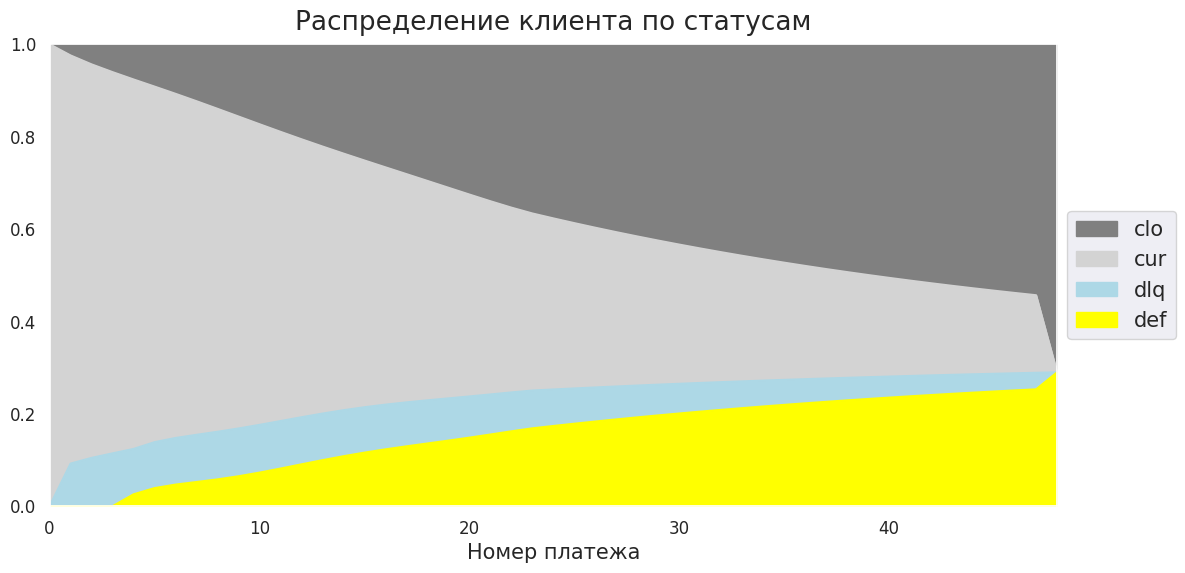

In [ ]:
act_dist, dlq_dist, cur_dist, def_dist, clo_dist = distribution_calc(0.05, 0.1, 48, df_def_rate, df_clo_rate, df_dlq_ratio)
plot_distribution(clo_dist, cur_dist, dlq_dist, def_dist, 48)

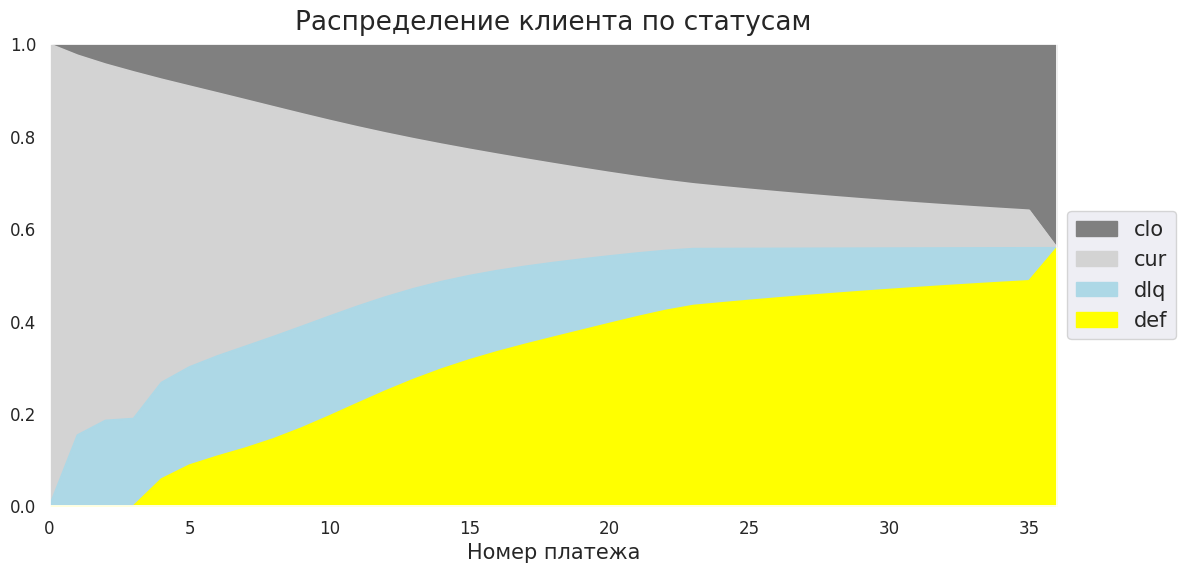

In [ ]:
act_dist, dlq_dist, cur_dist, def_dist, clo_dist = distribution_calc(0.2, 0.1, 36, df_def_rate, df_clo_rate, df_dlq_ratio)
plot_distribution(clo_dist, cur_dist, dlq_dist, def_dist, 36)

## Второе задание (изложение подхода к решению)

По своему содержанию, в страховке можно выделить две составляющие: прибыль от платежей клиента по страховке и выплаты клиенту по страховому случаю. Разберем каждый из них:

1. Прибыль от страховки зависит от текущего тела кредита и статуса клиента (вероятность наличия страховки у DEF и CUR различна). Соответственно, она будет считаться по следующим формулам:
$$ ins\_profit\_cur = principal\_bal\_cur * ins\_cur\_prob * ins\_cost = principal\_bal\_cur * 0.4 * 0.005 $$
$$ ins\_profit\_dlq = principal\_bal\_dlq * ins\_dlq\_prob * ins\_cost = principal\_bal\_dlq * 0.6 * 0.005 $$
$$ total\_ins\_profit = ins\_profit\_cur + ins\_profit\_dlq$$

   Альтернативно (вернее, как по факту и было сказано в задании) страховые премии могут зависеть не от текущего тела кредита, а от суммы кредита, то есть будет выплачиваться постоянный процент от первоначальной суммы кредита. При таком подходе (который, на мой взгляд, выглядит достаточно странным) формулы для расчет будут следующими:

   $$ ins\_profit\_cur = amount * cur\_dist * ins\_cur\_prob * ins\_cost = amount * cur\_dist * 0.4 * 0.005 $$
   $$ ins\_profit\_dlq = amount * dlq\_dist * ins\_dlq\_prob * ins\_cost = amount * dlq\_dist * 0.6 * 0.005 $$
   $$ total\_ins\_profit = ins\_profit\_cur + ins\_profit\_dlq$$

  В самом классе достаточно будет добавить эти расчеты в метод ```profit_calc```; для переключения между двумя типами расчетов добавлен флаг ```dynamic_ins``` (по умолчанию False, то есть расчет как в задании)

2. Потери от страховки зависят от текщуго полного долга кредита (то есть считается именно gross_balance) и статуса клиента (опять же, из-за разных вероятностей наличия страховок). Формулы для расчета приведены ниже:
$$ ins\_loss\_cur = gross\_bal\_cur * ins\_cur\_prob * ins\_prob = gross\_bal\_cur * 0.4 * 0.001 $$
$$ ins\_loss\_dlq = gross\_bal\_dlq * ins\_dlq\_prob * ins\_prob = principal\_bal\_dlq * 0.6 * 0.001 $$
$$ total\_ins\_loss = ins\_loss\_cur + ins\_loss\_dlq$$

  В самом классе достаточно будет добавить эти расчеты в метод ```loss_calc```. Кроме того, необходимо еще немного изменить расчет потоков клиентам, добавив туда выплаты по страховым случаям; по сути, просто добавить еще одно слагаемое в формулу для ```repayments``` в методе ```cashflow_calc``` (соответственно в сам метод придется передавть лоссы по страховке через еще один аргумент.

## Итоговый класс модели (с учетом первого и второго заданий)

Все внесенные изменения выделены множественными решетками сверху и снизу

In [ ]:
class NPVModel:

    avg_missed_payments = 1.5
    recovery = 0.50
    dlq_penalty_amount = 500
    oper_costs = 100
    collection_costs = 600
    tax_rate = 0.20
    discounting_rate = 0.30
    eq_req = 0.125
    cost_of_funds = 0.16
    dlq_ratio = np.ones(101)*0.20
    dlq_ratio[0] = 0
    acquisition_cost = 1000
    #######################################################################################
    # Добавляем константы, связанные со страховкой
    insurance_proba_cur = 0.4
    insurance_proba_dlq = 0.6
    insurance_cost = 0.005
    insurance_proba = 0.001
    #######################################################################################

    #######################################################################################
    def __init__(self, def_rate: pd.DataFrame, clo_rate: pd.DataFrame, dlq_ratio: pd.DataFrame):
        # Чтобы не передавать лишнего в метод npv, будем задавать данные для построения поведенческих кривых при инициализации
        self.def_rate = def_rate
        self.clo_rate = clo_rate
        self.dlq_ratio = dlq_ratio
    #######################################################################################

    def model_balance_calculations(self, amount, rate, term):
        '''
        Расчет модельных баланса, выплаченных процентов, регулярного платежа
        :param amount: Сумма кредита
        :param rate: Ставка
        :param term: Срок
        :return:
        balance : np.array(101) : остаток тела долга по кредиту на каждый месяц
        interest : np.array(101) : выплата по процентам каждый месяц
        regular_payment : float : размер регулярного платежа
        '''

        regular_payment = round(amount * (rate / 12) *\
                                (1 + (rate / 12)) / (1 - ((1 + rate / 12) ** (-term))))
        # График баланса и процентов
        balance = np.zeros(101)
        interest = np.zeros(101)
        balance[0] = amount

        for i in range(1, term + 1):
            int_payment = balance[i - 1] * rate / 12
            debt_payment = regular_payment - int_payment
            balance[i] = max(0, round(balance[i - 1] - debt_payment))
            interest[i] = int_payment
        return balance, interest, regular_payment

    #######################################################################################
    def interpolation(self, data: pd.DataFrame, score: float):
        '''
        Линейная интерполяция
        :param score: скор клиента
        :param data: кривая для интерполяции
        :return:
        result: np.array(101) : интерполированные значения кривой
        '''
        means = data.loc[0] # Cредние значения скоров в бакетах
        result = np.zeros(101) # Итоговый результат интеполяции

        # Смотрим, к какому интервалу между бакетами ближе
        if score >= means['1']:
            delta = data.loc[1:, "2"] - data.loc[1:, "1"]
            delta_score = means['2'] - means['1']
            # Смотрим, от какого бакета надо отсчитывать при интерполировании
            if score >= means['2']:
                score -= means['2']
                approx = data.loc[1:, "2"] + delta / delta_score * score
            else:
                score -= means['1']
                approx = data.loc[1:, "1"] + delta / delta_score * score
        else:
            delta = data.loc[1:, "1"] - data.loc[1:, "0"]
            delta_score = means['1'] - means['0']
            score -= means['0']
            approx = data.loc[1:, "0"] + delta / delta_score * score

        # Записываем полученную интерполяцию в result и забиваем последним значением до конца
        approx = approx.values
        result[1:25] = approx
        result[25:] = approx[-1]

        # Дополнительном устанавливаем границы сверху и снизу
        return result.clip(0, 1)

    def distribution_calc(self, pd_score:float, pa_score:float, term: int):
        '''
        Построение графика распределений клиентов
        :param pd_score: вероятность дефолта к 12-ому месяцу
        :param pa_score: вероятность полного досрочного погашения к 6-ому месяцу
        :param term: срок кредитования
        :return:
        cur_dist: np.array(101) : распределение статуса cur
        clo_dist: np.array(101) : распределение статуса clo
        dlq_dist: np.array(101) : распределение статуса dlq
        def_dist: np.array(101) : распределение статуса def
        '''
        # Интерполяция по значениям pd_score и pa_score
        def_rate = self.interpolation(self.def_rate, pd_score)
        clo_rate = self.interpolation(self.clo_rate, pa_score)
        dlq_ratio = self.interpolation(self.dlq_ratio, pd_score)

        # Инициализация распределений
        act_dist = np.zeros(101)
        def_dist = np.zeros(101)
        clo_dist = np.zeros(101)
        dlq_dist = np.zeros(101)
        cur_dist = np.zeros(101)

        # В начальный момент времени клиент всегда находится в статусе cur
        act_dist[0] = 1
        cur_dist[0] = 1

        # Итеративный пересчет распределений клиента по состояниям
        for i in range(1, term + 1):
            # Невозвратные состояния
            clo_dist[i] = clo_dist[i - 1] + clo_rate[i] * act_dist[i - 1]
            def_dist[i] = def_dist[i - 1] + def_rate[i] * act_dist[i - 1]

            # Возвратные состояния
            act_dist[i] = 1 - clo_dist[i] - def_dist[i]
            dlq_dist[i] = act_dist[i] * dlq_ratio[i]
            cur_dist[i] = act_dist[i] - dlq_dist[i]

        # Обрубание в конце срока кредита: все кто остался в cur попадают в clo, а кто в dlq - в def
        clo_dist[term] += cur_dist[term]
        cur_dist[term] = 0
        def_dist[term] += dlq_dist[term]
        dlq_dist[term] = 0


        return act_dist, dlq_dist, cur_dist, def_dist
    #######################################################################################

    def cur_balance_calc(self, model_balance, cur_dist):
        '''
        Расчет модельного баланса в статусе CUR
        :param model_balance: плановый график баланса
        :param cur_dist: доля клиентов в статусе CUR на каждый месяц
        :return:
        principal_balance_cur : np.array(101) : principal balance в статусе CUR
        gross_balance_cur : np.array(101) : gross balance в статусе CUR
        '''
        principal_balance_cur = model_balance*cur_dist
        gross_balance_cur = model_balance*cur_dist
        return principal_balance_cur, gross_balance_cur

    def dlq_balance_calc(self, model_balance, regular_payment, dlq_dist):
        '''
        Расчет модельного баланса в статусе DLQ
        :param model_balance: плановый график баланса
        :param regular_payment: размер регулярного платежа
        :param dlq_dist: доля клиентов в статусе DLQ на каждый месяц
        :return:
        principal_balance_dlq : np.array(101) : principal balance в статусе DLQ
        gross_balance_dlq : np.array(101) : gross balance в статусе DLQ
        '''
        principal_balance_dlq = np.append(model_balance[1:], model_balance[-1])*dlq_dist
        gross_balance_dlq = (model_balance + regular_payment*self.avg_missed_payments)*dlq_dist
        return principal_balance_dlq, gross_balance_dlq

    def act_balance_calc(self, principal_balance_cur, principal_balance_dlq, gross_balance_cur, gross_balance_dlq):
        '''
        Расчет модельного баланса в статусе ACT
        :param principal_balance_cur: principal balance в статусе CUR
        :param principal_balance_dlq: principal balance в статусе DLQ
        :param gross_balance_cur: principal balance в статусе CUR
        :param gross_balance_dlq: principal balance в статусе DLQ
        :param dlq_dist: доля клиентов в статусе DLQ на каждый месяц
        :return:
        principal_balance_act : np.array(101) : principal balance в статусе ACT
        gross_balance_act : np.array(101) : gross balance в статусе ACT
        '''
        principal_balance_act = principal_balance_cur + principal_balance_dlq
        gross_balance_act = gross_balance_cur + gross_balance_dlq
        return principal_balance_act, gross_balance_act

    def def_balance_calc(self, model_balance, regular_payment, def_dist):
        '''
        Расчет модельного баланса в статусе DEF
        :param model_balance: плановый график баланса
        :param regular_payment: размер регулярного платежа
        :param def_dist: доля клиентов в статусе DEF на каждый месяц
        :return:
        principal_balance_def : np.array(101) : principal balance в статусе DEF
        gross_balance_def : np.array(101) : gross balance в статусе DEF
        '''
        principal_balance_def = np.zeros(101)
        gross_balance_def = np.zeros(101)

        def_dist_change = def_dist[4:] - def_dist[3:-1]
        principal_balance_def[4:] = np.cumsum(model_balance[:-4] * def_dist_change)
        gross_balance_def[4:] = np.cumsum((model_balance[4:] + 4 * regular_payment) * def_dist_change)

        return principal_balance_def, gross_balance_def

    def profit_calc(self, principal_balance_dlq, principal_balance_cur, principal_balance_act, principal_balance_def, term, rate, dlq_dist, cur_dist, dynamic=False):
        '''
        #######################################################################################
        :param principal_balance_dlq: principal balance в статусе DLQ
        :param principal_balance_cur: principal balance в статусе CUR
        :param dynamic: способ расчета страховых премий (статичный/динамический)
        #######################################################################################
        :param principal_balance_act: principal balance в статусе ACT
        :param principal_balance_def: principal balance в статусе DEF
        :param term: срок кредита
        :param rate: тавка по кредиту
        :param dlq_dist: доля клиентов в статусе DLQ на каждый месяц
        :param cur_dist: доля клиентов в статусе CUR на каждый месяц
        :return:
        profit : np.array(101) : доход на каждый месяц
        '''
        interest_profit = principal_balance_act*rate/12
        penatly_profit = dlq_dist*self.dlq_penalty_amount

        new_def_balance = np.append(principal_balance_def[1:], 0) - principal_balance_def
        recovery_profit = new_def_balance*self.recovery

        #######################################################################################
        # Считаем прибыль от страховки по каждому статусу, общую и приблаем к итоговой прибыли
        if dynamic:
            # Динамический расчет страховых премий (то есть процент от текущего тела кредита)
            insurance_profit_cur = principal_balance_cur * self.insurance_proba_cur * self.insurance_cost
            insurance_profit_dlq = principal_balance_dlq * self.insurance_proba_dlq * self.insurance_cost
        else:
            # Статичный расчет страховых премий (то есть процент от суммы кредита)
            insurance_profit_cur = principal_balance_act[0] * cur_dist * self.insurance_proba_cur * self.insurance_cost
            insurance_profit_dlq = principal_balance_act[0] * dlq_dist * self.insurance_proba_dlq * self.insurance_cost

        insurance_profit = insurance_profit_cur + insurance_profit_dlq

        profit = interest_profit + recovery_profit + penatly_profit + insurance_profit
        #######################################################################################

        profit[term+1:] = 0

        return profit

    def loss_calc(self, gross_balance_cur, gross_balance_dlq, gross_balance_act, principal_balance_def, term, act_dist, dlq_dist, def_dist):
        '''
        #######################################################################################
        :param gross_balance_cur: gross balance в статусе CUR
        :param gross_balance_dlq: gross balance в статусе DLQ
        #######################################################################################
        :param gross_balance_act: gross balance в статусе ACT
        :param principal_balance_def: principal balance в статусе DEF
        :param term: срок кредита
        :param act_dist: доля клиентов в статусе ACT на каждый месяц
        :param dlq_dist: доля клиентов в статусе DLQ на каждый месяц
        :param def_dist: доля клиентов в статусе DEF на каждый месяц
        :return:
        loss : np.array(101) : лосс на каждый месяц
        '''
        oper_loss = np.append(act_dist[1:], 0)*self.oper_costs
        loan_loss =  principal_balance_def - np.append(0, principal_balance_def[:-1])
        collection_loss = (np.append(dlq_dist[1:], 0) + np.append(def_dist[1:], 0))*self.collection_costs

        prev_gross_balance_act = np.append(gross_balance_act[0], gross_balance_act[1:])
        cost_of_funds_loss = prev_gross_balance_act*(1 - self.eq_req)*self.cost_of_funds/12

        #######################################################################################
        # Считаем убытки от страховки по каждому статусу, общую и прибавляем к итоговым убыткам
        insurance_loss_cur = gross_balance_cur * self.insurance_proba_cur * self.insurance_proba
        insurance_loss_dlq = gross_balance_dlq * self.insurance_proba_dlq * self.insurance_proba
        insurance_loss = insurance_loss_cur + insurance_loss_dlq

        loss = loan_loss + cost_of_funds_loss + oper_loss + collection_loss + insurance_loss
        #######################################################################################

        loss[term+1:] = 0

        # Убытки от страховки так же возвращаем
        return loss, loan_loss, cost_of_funds_loss, oper_loss, collection_loss, insurance_loss

    def assets_liabilities_calc(self, gross_balance_act):
        '''

        :param gross_balance_act: gross balance в статусе ACT
        :return:
        assets : np.array(101) : активы в проекте
        eq_req_curve : np.array(101) : активы, обеспеченные капиталом
        fund_req_curve : np.array(101) : активы, обеспеченные фондами
        '''

        # assets
        assets = gross_balance_act

        #liabilities
        eq_req_curve = assets*self.eq_req
        fund_req_curve = assets*(1 - self.eq_req)

        return assets, eq_req_curve, fund_req_curve

    def niat_calc(self, profit, loss):
        '''
        Расчет NIAT
        :param profit: суммарный доход на каждый месяц
        :param loss: суммарный лосс на каждый месяц
        :return:
        nibt : np.array(101) : прибыль до налогообложения
        niat : np.array(101) : прибыль после налогообложения
        tax : np.array(101) : налог в каждом месяце
        '''

        nibt = profit - loss
        tax = nibt*self.tax_rate
        niat = nibt - tax

        return nibt, niat, tax

    def cashflow_calc(self, principal_balance_act, principal_balance_def, amount, profit,
                      cost_of_funds_loss, insurance_loss, oper_costs, collection_costs, tax, niat, eq_req_curve, fund_req_curve):
        '''
        Расчет денежных потоков
        :param principal_balance_act: principal balance в статусе DEF
        :param principal_balance_def: principal balance в статусе DEF
        :param amount: срок кредита
        :param profit: доход на каждый месяц
        :param cost_of_funds_loss: лоссы на фондирование
        #######################################################################################
        :param insurance_loss: лоссы на страховку
        #######################################################################################
        :param oper_costs: операционные расходы
        :param collection_costs: расходы на коллекшн
        :param tax: налог в каждом месяце
        :param niat: доход после налогообложения
        :param eq_req_curve: активы, обеспеченные капиталом
        :param fund_req_curve: активы, обеспеченные фондами
        :return:
        cf_to_client : np.array(101) : денежный поток к клиенту
        cf_to_shareholders : np.array(101) : денежный поток к акционерам
        cf_to_debtholders : np.array(101) : денежный поток к фондам
        cf_to_cost_and_tax : np.array(101) : денежный поток на косты и налоги
        '''
        # client
        delta_principal_balance_act = (np.append(0, principal_balance_act[:100]) - principal_balance_act)
        delta_principal_balance_def = (np.append(0, principal_balance_def[:100]) - principal_balance_def)
        #######################################################################################
        # В подсчет выплат клиентам включаем страховку
        repayments = delta_principal_balance_act - delta_principal_balance_def + profit - insurance_loss
        #######################################################################################
        cf_to_client = np.append(amount, -repayments[1:])

        # debtoholder
        fund_req_ch = fund_req_curve - np.append(fund_req_curve[0], fund_req_curve[:-1])
        fund_req_change = np.append(fund_req_curve[0], fund_req_ch[1:])
        cf_to_debtholders = cost_of_funds_loss - fund_req_change

        # shareholders
        eq_req_ch = eq_req_curve - np.append(eq_req_curve[0], eq_req_curve[:-1])
        cf_to_shareholders = niat - np.append(eq_req_curve[0], eq_req_ch[1:])

        # cost and tax
        cf_to_cost_and_tax = oper_costs + collection_costs + tax

        return cf_to_client, cf_to_shareholders, cf_to_debtholders, cf_to_cost_and_tax

    def npv_calc(self, pd, pa, amount, rate, term, dynamic_ins=False):
        '''
        Расчет NPV
        :param pd: вероятность дефолта к 12-ому месяцу
        :param pa: вероятность полного досрочного погашения к 6-ому месяцу
        :param amount: сумма кредита
        :param rate: ставка по кредиту
        :param term: срок кредита
        #######################################################################################
        :param dynamic_ins: способ расчета страховых премий (статичный/динамический)
        #######################################################################################
        :return:
        npv: чистая приведенная стоимость кредита
        '''

        # Считаем балансы
        model_balance, interest, regular_payment =  self.model_balance_calculations(amount, rate, term)

        # Считаем распределение
        act_dist, dlq_dist, cur_dist, def_dist = self.distribution_calc(pd, pa, term)

        # Считаем балансы в различных статусах
        principal_balance_cur, gross_balance_cur = self.cur_balance_calc(model_balance, cur_dist)
        principal_balance_dlq, gross_balance_dlq = self.dlq_balance_calc(model_balance, regular_payment, dlq_dist)
        principal_balance_act, gross_balance_act = self.act_balance_calc(principal_balance_cur, principal_balance_dlq, gross_balance_cur, gross_balance_dlq)
        principal_balance_def, gross_balance_def = self.def_balance_calc(model_balance, regular_payment, def_dist)

        # Считаем профиты, лосcы и niat
        profit = self.profit_calc(principal_balance_dlq, principal_balance_cur, principal_balance_act, principal_balance_def, term, rate, dlq_dist, cur_dist, dynamic_ins)
        loss, loan_loss, cost_of_funds_loss, oper_loss, collection_loss, insurance_loss = self.loss_calc(gross_balance_cur,gross_balance_dlq,  gross_balance_act,
                                                                                                         principal_balance_def, term, act_dist, dlq_dist, def_dist)
        nibt, niat, tax = self.niat_calc(profit, loss)

        # Считаем активы и денежные потоки
        assets, eq_req_curve, fund_req_curve = self.assets_liabilities_calc(gross_balance_act)
        cf_to_client, cf_to_shareholders, cf_to_debtholders, cf_to_cost_and_tax =\
            self.cashflow_calc(principal_balance_act, principal_balance_def, amount, profit, cost_of_funds_loss, oper_loss, collection_loss, insurance_loss,
                               tax, niat, eq_req_curve, fund_req_curve)

        # Считаем NPV
        disc_curve = np.array([1 / ((1 + self.discounting_rate) ** (i / 12.)) for i in range(101)])
        pv = np.round(np.sum(disc_curve * cf_to_shareholders)).astype(int)
        npv = pv - self.acquisition_cost

        return npv

В конце, создадим модель и проверим, что она улавливает основные паттерны изменений параметров

In [ ]:
model = NPVModel(df_def_rate, df_clo_rate, df_dlq_ratio)

In [ ]:
# Повышение pd
model.npv_calc(pd=0.05, pa=0.25, amount=500_000, term=36, rate=0.25), model.npv_calc(pd=0.08, pa=0.25, amount=500_000, term=36, rate=0.25)

(7534, -389)

In [ ]:
# Повышение pa
model.npv_calc(pd=0.05, pa=0.25, amount=500_000, term=36, rate=0.25), model.npv_calc(pd=0.05, pa=0.65, amount=500_000, term=36, rate=0.25)

(7534, 5646)

In [ ]:
# Повышение amount
model.npv_calc(pd=0.05, pa=0.25, amount=500_000, term=36, rate=0.25), model.npv_calc(pd=0.05, pa=0.25, amount=1_000_000, term=36, rate=0.25)

(7534, 18201)

In [ ]:
# Повышение term
model.npv_calc(pd=0.05, pa=0.25, amount=500_000, term=36, rate=0.25), model.npv_calc(pd=0.05, pa=0.25, amount=500_000, term=48, rate=0.25)

(7534, 9039)

In [ ]:
# Повышение rate
model.npv_calc(pd=0.05, pa=0.25, amount=500_000, term=36, rate=0.25), model.npv_calc(pd=0.05, pa=0.25, amount=500_000, term=36, rate=0.4)

(7534, 56277)

In [ ]:
# Изменение расчета страховых премий
model.npv_calc(pd=0.05, pa=0.25, amount=500_000, term=36, rate=0.25), model.npv_calc(pd=0.05, pa=0.25, amount=500_000, term=36, rate=0.25, dynamic_ins=True)

(7534, 4906)